# A preliminary pipeline to collect features

In [1]:
import jusipy
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Load datasets
LM        = jusipy.deals.LandMatrix()
A_country = jusipy.country_features.All()
A_latlong = jusipy.latlong_features.All()
GLCF_8km  = A_latlong.datasets[2]         # extract from A_latlong, just to not load this one twice...

Loading GLCF(8km)                                                                                                     reas)                                                                                                      

In [3]:
# Load GIS tools
GC = jusipy.GIS.GoogleCode(cache=jusipy.utils.FireDict(sub='googlecode'))
CC = jusipy.GIS.CountryCode()
CLL = jusipy.GIS.CountryLatLong()

## Select the points, and get the relevant data

### Positive points from LandMatrix

In [21]:
positive_points = LM.M[['lat', 'long', 'target_country_iso3', 'negotiation_year']]
positive_points = positive_points.rename(columns={'target_country_iso3' : 'country',
                                                  'negotiation_year' : 'year'})
positive_points['positive'] = 1
positive_points['random']   = 0
positive_points['year'] = positive_points.year.apply(lambda x: 'newest' if pd.isna(x) else x)

### Random points selected from around the earth

In [6]:
random_points = pd.DataFrame(jusipy.GIS.sample.random_latlong(land=True, glcf=GLCF_8km, size=11000),
                             columns=['lat', 'long'])
random_points.to_pickle('data/random_points.pkl')
random_points = pd.read_pickle('data/random_points.pkl')
random_points['country'] = CLL.get(zip(random_points.lat, random_points.long))

random_points['year'] = ['newest'] * len(random_points.lat)
random_points['positive'] = 0
random_points['random']   = 1

random_points = random_points[~pd.isna(random_points.country)]

### Combine the two stacks of data

In [4]:
#all_points = pd.concat([positive_points, random_points])
#all_points.to_pickle('data/all_points.pkl')
#all_points
all_points = pd.read_pickle('data/all_points.pkl')

## Visualize the selected points

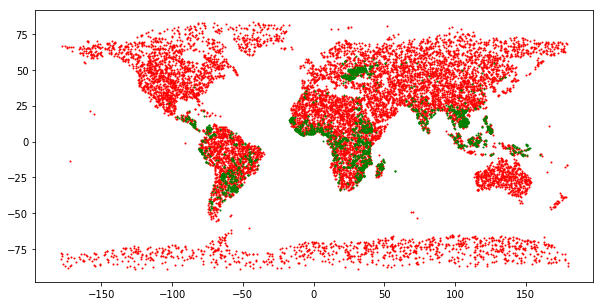

In [9]:
plt.figure(figsize=(10,5))
cb = plt.scatter(all_points.long[all_points.random == 1], all_points.lat[all_points.random ==1], c='r', s=1, zorder=1)

plt.scatter(all_points.long[all_points.random == 0], all_points.lat[all_points.random ==0], c='g', s=1, zorder=2)


## Collect features for each point

In [1]:
import jusipy
import pandas as pd
all_points = pd.read_pickle('data/all_points.pkl')
ne = jusipy.latlong_features.NaturalEarth()
#country_features = jusipy.country_features.get(all_points, A_country)
latlong_features = jusipy.latlong_features.get(all_points, ne)
#all_features = country_features.join(latlong_features)

Loading NaturalEarth(/Users/thiesgehrmann/repos/JuSiPy_Asser/jusipy/latlong_features/data/natural_earth/ne_10m_urban_areas)                                                                                                    

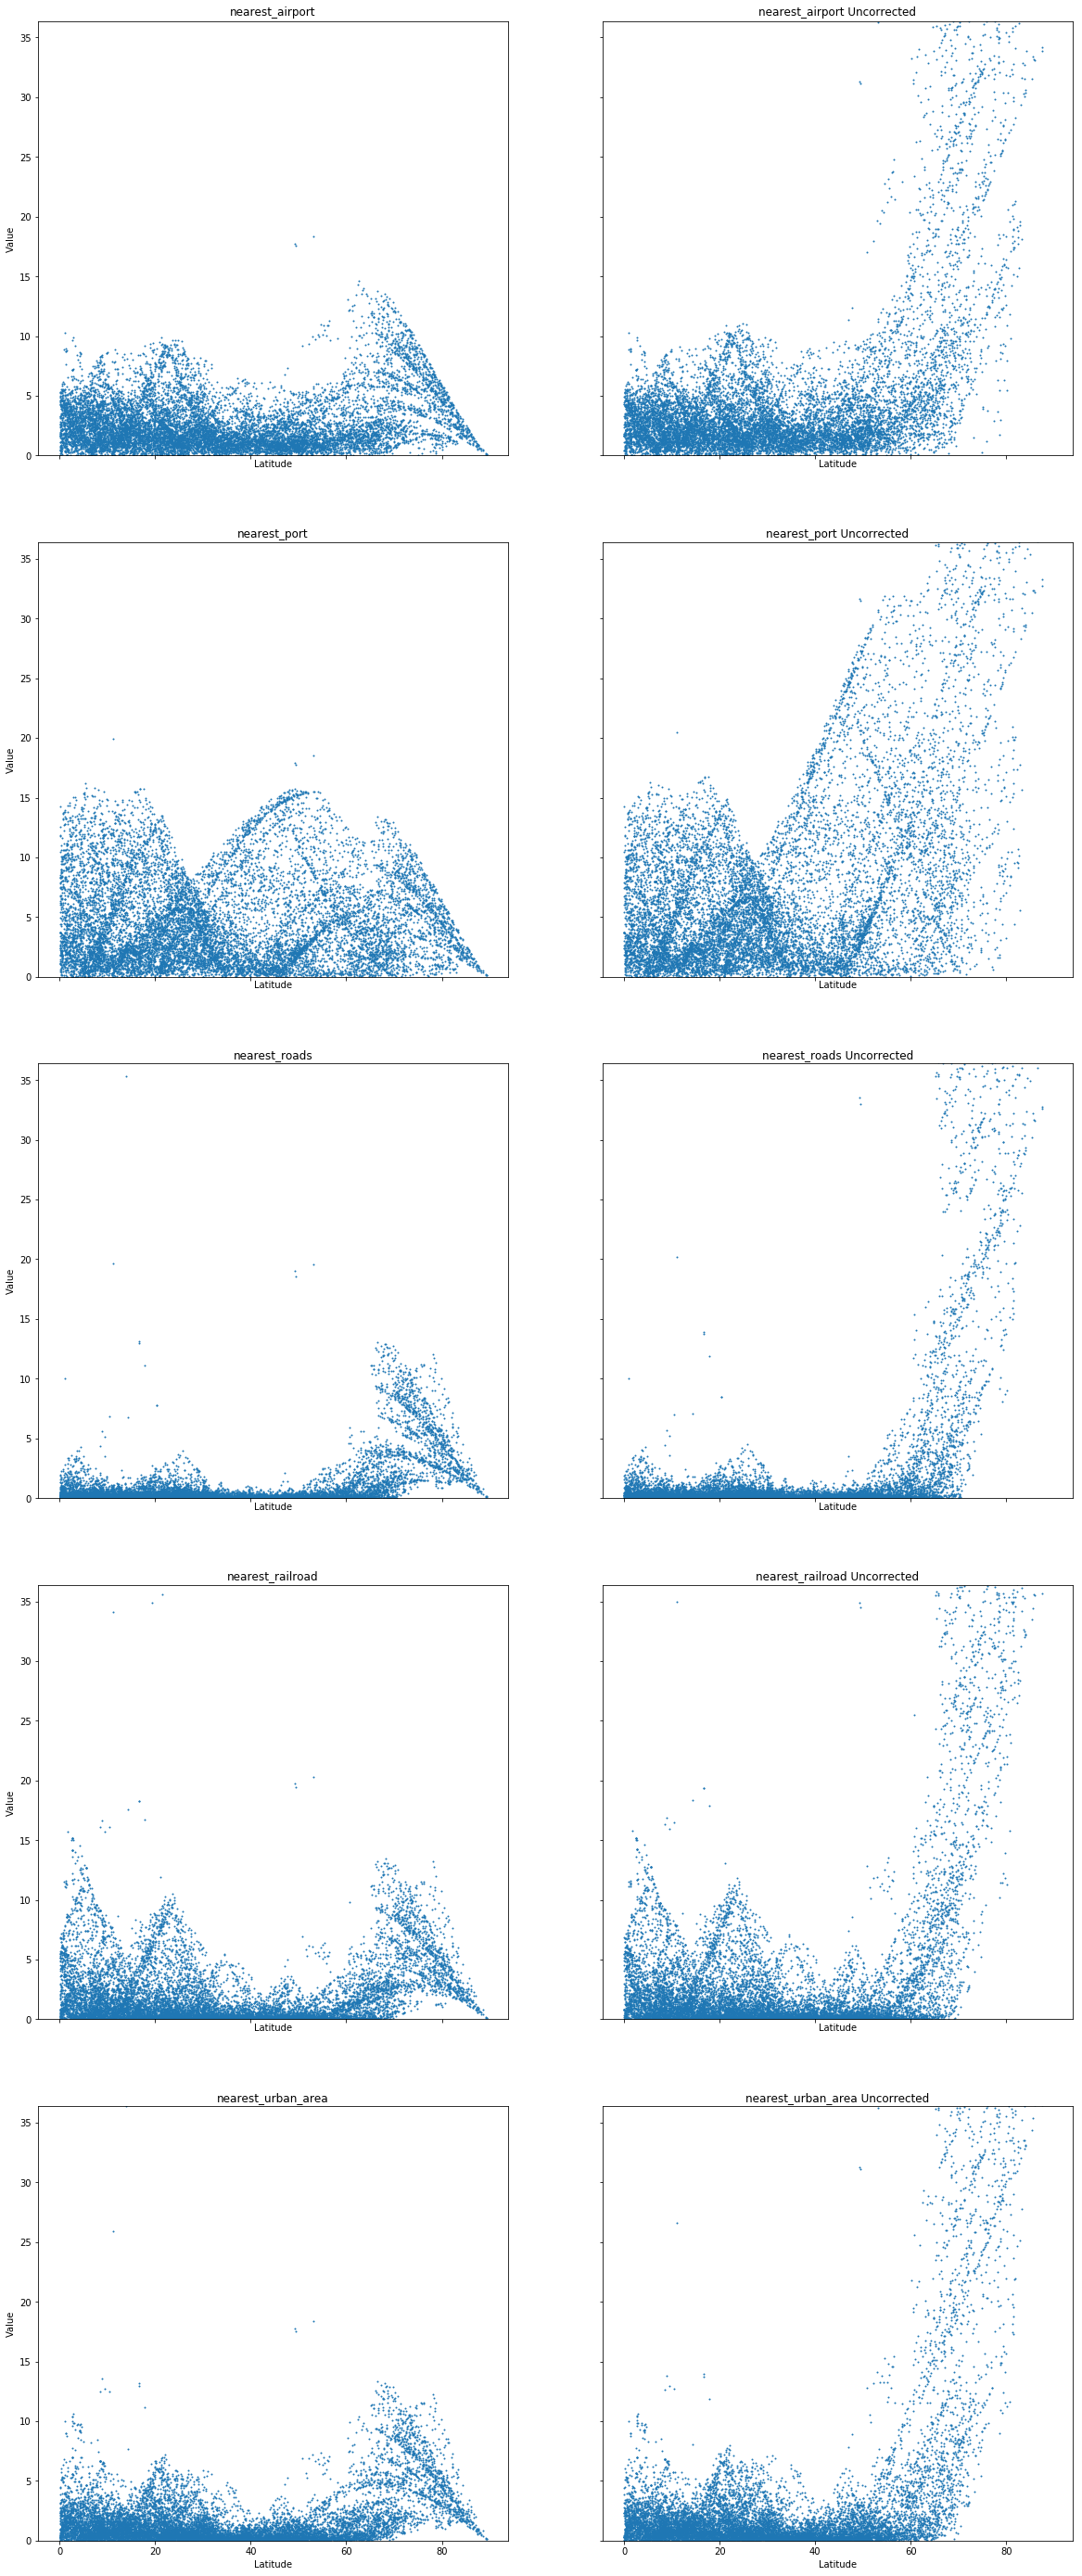

In [4]:
import numpy as np
import matplotlib.pylab as plt
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20,50), sharex=True, sharey=True)

for i, col in enumerate([ c for c in latlong_features.columns if 'nearest' in c]):
    axes[i,0].scatter(np.abs(all_points.lat), latlong_features[col], s=1)
    axes[i,0].set_ylim([0, max(latlong_features[col])])
    axes[i,0].set_title(col)
    axes[i,0].set_ylabel('Value')
    axes[i,0].set_xlabel('Latitude')
    corr = [ ((np.cos(np.pi*(lat/90))+1)/2)**(1/1.5) for lat in all_points.lat]
    axes[i,1].scatter(np.abs(all_points.lat), latlong_features[col] / corr, s=1)
    axes[i,1].set_ylim([0, max(latlong_features[col])])
    axes[i,1].set_title(col + ' Uncorrected')
    axes[i,1].set_xlabel('Latitude')
    

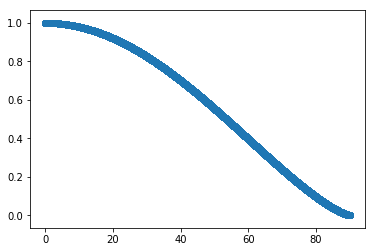

In [14]:
r = np.arange(0, 90, 1/1000)
plt.scatter(r, ((np.cos(np.pi*(r/90))+1)/2)**(1/1.5))

## Store the output

In [ ]:
all_points.to_pickle('data/all_labels.pkl')
all_features.to_pickle('data/all_features.pkl')

In [9]:
len(GC._cache._cache.keys())

5010

In [26]:
latlong_features = latlong_features.drop(columns=['coding_error_do_not_use_feature'])

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

class Negative(object):
    """
    Identify potentially negative deals from a random selection

    Neg = Negative(slabels, features, positive_col='positive', autorun=True, **kwargs)
        labels: A dataframe of labels
        features: A dataframe of features (columns are features) Must be none missing! Index corresponds to index of labels
        positive_col : String. The name of the column you want to use in the labels dataframe
        autorun: Run the pipeline automatically
        **kwargs: Arguments for each step (see pca, tsne, cluster and negatives for the parameters)

    properties:
        negatives: A numpy array of labels for each point, corresponding to the input dataframes
                   1 means negative, 0 means positive/not negative

    """
    def __init__(self, labels, features, positive_col='positive', autorun=True, **kwargs):
        """
        Inputs:
            labels: a dataframe of labels
            features: A dataframe of features (columns are features) Must be none missing! Index corresponds to index of labels
            positive_col : String. The name of the column you want to use in the labels dataframe
            autorun: Run the pipeline automatically
            **kwargs: Arguments for each step (see pca, tsne, cluster and negatives for the parameters)
        Output:
            A Negative structure.
            The negative labels can be retrieved with the property 'negatives'

        """
        self._labels    = labels
        self._features  = features
        self._positives = self._labels[positive_col].values
        self._znorm     = None
        self._pca       = None
        self._tsne      = None
        self._clusters  = None
        self._negatives = None
        if autorun:
            self.run(**kwargs)
        #fi
    #edef

    def run(self, **kwargs):
        """
        Run the negative selection pipeline
        """
        if self._znorm is None:
            self.znorm(**kwargs)
        #fi
        if self._pca is None:
            self.pca(**kwargs)
        #fi
        if self._tsne is None:
            self.tsne(**kwargs)
        #fi
        if self._clusters is None:
            self.cluster(**kwargs)
        #fi
        if self._negatives is None:
            self.get_negatives(**kwargs)
        #fi
        return self._negatives
    #edef

    @property
    def negatives(self, **kwargs):
        return self._negatives
    #edef

    def znorm(self, do_znorm=True, **kwargs):
        if (self._features is None) or not (do_znorm):
            self._znorm = self._features
            return None
        #fi
        print('\rPerforming z-normalization for all features')
        self._znorm = (self._features - self._features.mean()) / self._features.std()
        return self._znorm

    def pca(self, **kwargs):
        if self._znorm is None:
            return None
        #fi
        print('\rPerforming PCA')
        pca  = PCA(n_components=2)
        pca_features  = pca.fit_transform(self._znorm)
        self._pca = pca_features
        return self._pca
    #edef

    def tsne(self, **kwargs):
        if self._znorm is None:
            return None
        #fi
        print('\rPerforming TSNE')
        tsne = TSNE(n_components=2)
        tsne_features = tsne.fit_transform(self._znorm)
        self._tsne = tsne_features
        return self._tsne
    #edef

    def cluster(self, tsne=True, method='meanshift', bandwidth=10, **kwargs):
        """
        Cluster the embedded data
        Input:
            tsne: Boolean. Use the TSNE data. False means use PCA
            method: ['meanshift', 'gmm', callable object]
            **kwargs: arguments for the specific clustering method
        Output:
            an array of cluster IDs (of length # of points in dataset)
        """

        data = self._tsne if tsne else self._pca

        if data is None:
            return None
        #fi
        method = method.lower()
        print('\rPerforming Clustering')
        self._clusters = None
        if method == 'gmm':
            self._clusters = GaussianMixture(**kwargs).fit_predict(data)
        elif method == 'meanshift':
            self._clusters = MeanShift(bandwidth=bandwidth, **kwargs).fit(data).labels_
        elif hasattr(method, '__call__'):
            self._clusters = method(data)
        else:
            self._clusters = None
        #fi
        return self._clusters
    #edef

    def get_negatives(self, threshold=0.95, **kwargs):
        if self._clusters is None:
            return None
        #fi
        def select_negative_clusters(cluster_labels, positive_labels, threshold=.95):
            """
            Select negative clusters based on some clustering of the TSNE space
            Inputs:
                cluster_labels:  np.array: labels from the clustering
                positive_labels: np.array: labels with true positives (0 is unknown/negative, 1 is true positive)
                threshold:       The % of negative samples per cluster that are required to call it negative (default 0.95)
                                 (i.e. 0.05 positive)
            Outputs:
                a list of cluster label IDs that constitute negative clusters
            """
            clusters = list(range(max(cluster_labels)+1))
            neg_clusters = []
            for clust in clusters:
                clust_positive = positive_labels[np.where(cluster_labels == clust)]
                if (sum(clust_positive) / float(len(clust_positive))) < (1-threshold):
                    neg_clusters.append(clust)
                #fi
            #efor
            return neg_clusters
        #edef

        def select_negative_points(cluster_labels, positive_labels, threshold=0.95):
            """
            Select negative clusters based on some clustering of the TSNE space
            Inputs:
                cluster_labels:  np.array: labels from the clustering
                positive_labels: np.array: labels with true positives (0 is unknown/negative, 1 is true positive)
                threshold:       The % of negative samples per cluster that are required to call it negative (default 0.95)
                                 (i.e. 0.05 positive)
            Outputs:
                An array of negative (0) and positive (1) labels
            """
            negative_clusters = select_negative_clusters(cluster_labels, positive_labels, threshold)
            labels = np.array([ 1 ] * len(cluster_labels))
            for nc in negative_clusters:
                labels[np.where(cluster_labels == nc)] = 0
            #efor
            # Correct the true positive points we had which lie in negative clusters
            labels[np.where(positive_labels == 1)] = 1
            return negative_clusters, 1-labels
        #edef
        print('\rSelecting negatives')
        neg_clusters, negatives = select_negative_points(self._clusters, self._positives, threshold=threshold)
        self._neg_clusters = np.array([ 1 if c in neg_clusters else 0 for c in self._clusters ])
        self._negatives = negatives
        return negatives
    #edef

    def plot(self):
        """
        Plot the results of the pipeline
        """
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
        axes = [ ax for row in axes for ax in row ]
        
        positive_color = '#1b9e77'
        random_color   = '#d95f02'
        negative_color = '#7570b3'

        if self._pca is not None:
            axes[0].set_title('PCA embedding')
            axes[0].scatter(*list(zip(*self._pca[self._positives==1,:])), c=positive_color, s=1, zorder=2, label='positive')
            axes[0].scatter(*list(zip(*self._pca[self._positives==0,:])), c=random_color, s=1, zorder=1, alpha=0.5, label='random')
            axes[0].set_xlabel('PCA Component 1')
            axes[0].set_ylabel('PCA Component 2')
            axes[0].legend()
        #fi

        if self._tsne is not None:
            axes[1].set_title('TSNE embedding')
            axes[1].scatter(*list(zip(*self._tsne[self._positives==1,:])), c=positive_color, s=1, zorder=2, label='positive')
            axes[1].scatter(*list(zip(*self._tsne[self._positives==0,:])), c=random_color, s=1, zorder=1, label='random')
            axes[1].set_xlabel('TSNE Component 1')
            axes[1].set_ylabel('TSNE Component 2')
            axes[1].legend()
        #fi

        if self._clusters is not None:
            axes[2].set_title('TSNE clustering')
            axes[2].scatter(*list(zip(*self._tsne)), c=self._clusters, s=1)
            axes[2].set_xlabel('TSNE Component 1')
            axes[2].set_ylabel('TSNE Component 2')
            axes[2].legend()
        #fi
        
        if self._negatives is not None:
            axes[3].set_title('Negative annotation')
            axes[3].scatter(*list(zip(*self._tsne[self._neg_clusters==1,:])), c=positive_color, s=1, zorder=3, label='positive')
            axes[3].scatter(*list(zip(*self._tsne[self._neg_clusters==0,:])), c=negative_color, s=1, zorder=2, label='negative')
            axes[3].set_xlabel('TSNE Component 1')
            axes[3].set_ylabel('TSNE Component 2')
            axes[3].legend()
        #fi

        if self._negatives is not None:
            axes[4].set_title('Negative annotation')
            axes[4].scatter(*list(zip(*self._tsne[self._positives==1,:])), c=positive_color, s=1, zorder=3, label='positive')
            axes[4].scatter(*list(zip(*self._tsne[self._negatives==1,:])), c=negative_color, s=1, zorder=2, label='negative')
            axes[4].scatter(*list(zip(*self._tsne[((self._negatives==0) & (self._positives==0)),:])),
                            c=random_color, s=1, zorder=1, label='random')
            axes[4].set_xlabel('TSNE Component 1')
            axes[4].set_ylabel('TSNE Component 2')
            axes[4].legend()
        #fi
        
        if (self._negatives is not None) and ('lat' in self._labels.columns) and ('long' in self._labels.columns):
            lat = self._labels.lat
            long = self._labels.long
            axes[5].set_title('World location')
            axes[5].scatter(long[self._positives==1], lat[self._positives==1],
                            c=positive_color, s=1, zorder=3, label='positive')
            axes[5].scatter(long[self._negatives==1], lat[self._negatives==1],
                            c=negative_color, s=1, zorder=2, label='negative')

            axes[5].set_xlabel('TSNE Component 1')
            axes[5].set_ylabel('TSNE Component 2')
            axes[5].legend()
        #fi

        return fig, axes

    #edef

#eclass


#neg = Negative(all_points, latlong_features, autorun=False)

In [53]:
'long' in neg._labels.columns

True

In [41]:
#neg.run()
Negative.get_negatives(neg)

Selecting negatives


array([0, 0, 0, ..., 0, 0, 0])

No handles with labels found to put in legend.


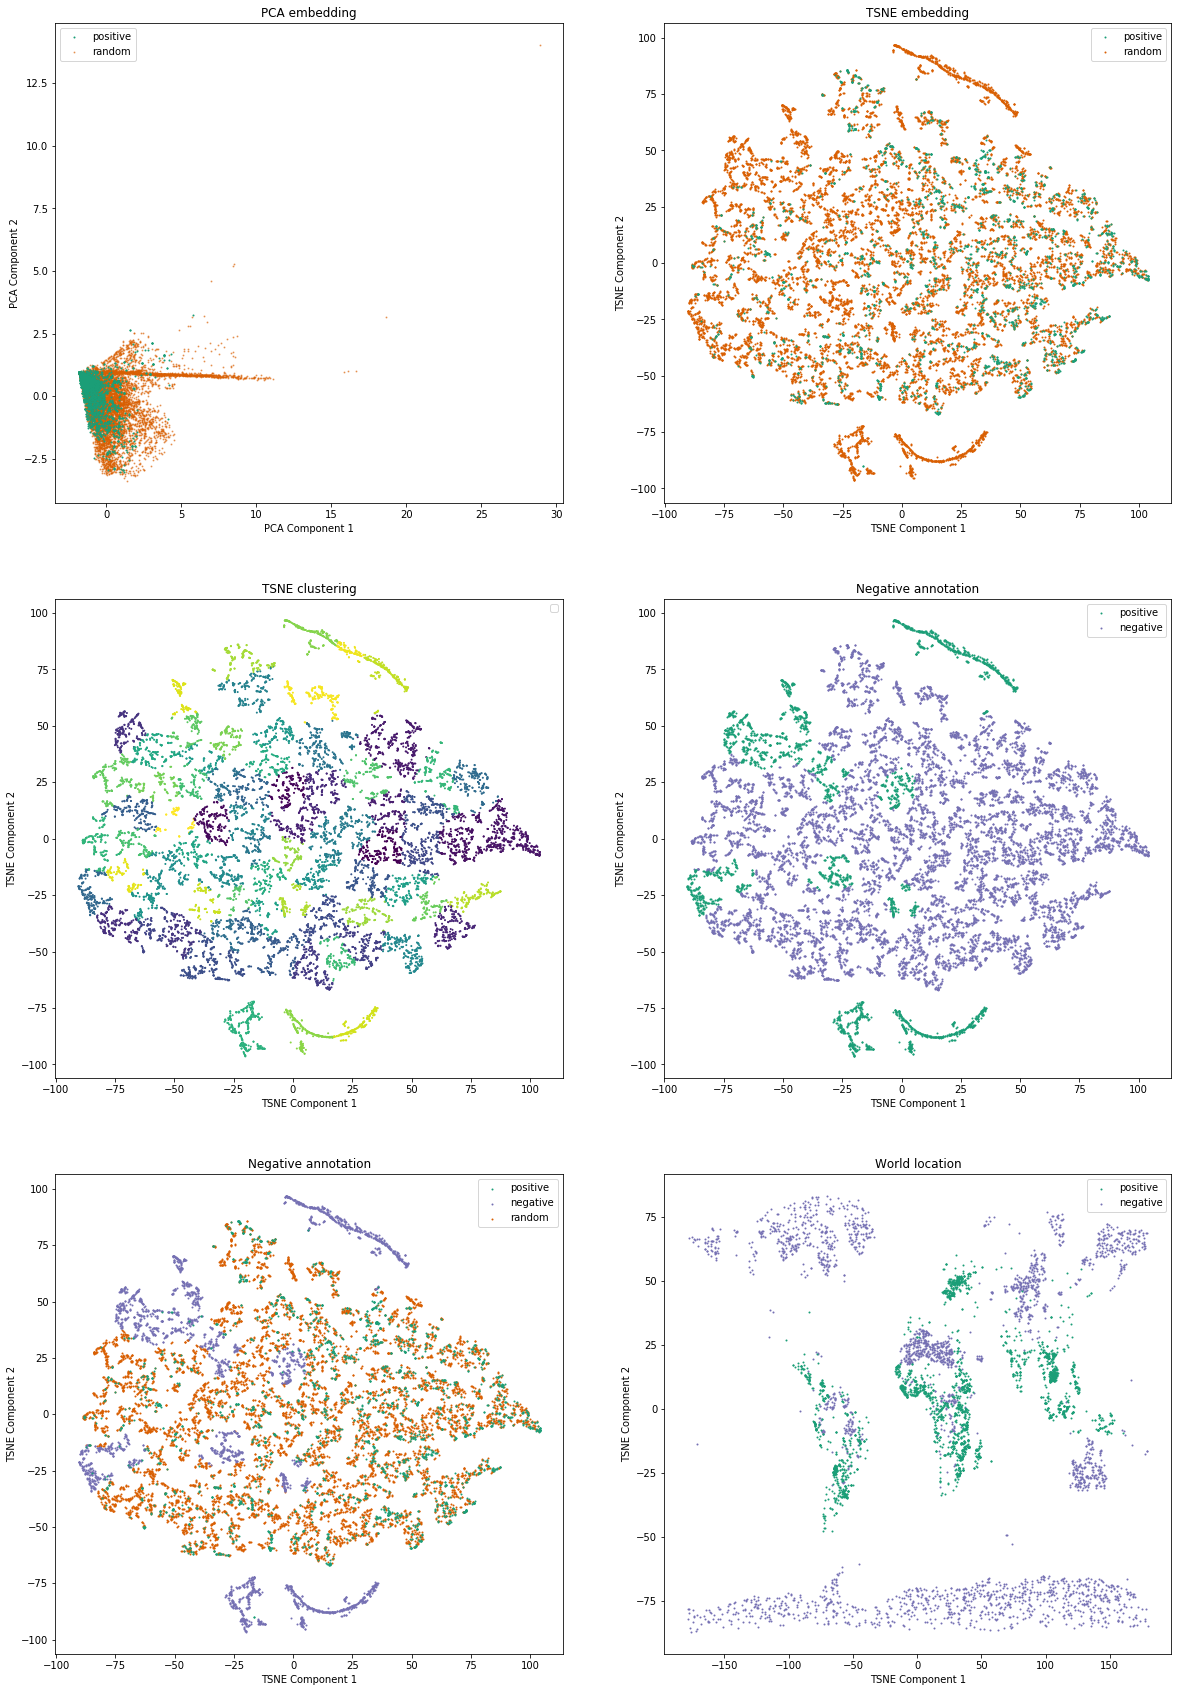

In [55]:
fig, axes = Negative.plot(neg)

In [57]:
#https://mrdata.usgs.gov/mrds/mrds-csv.zip
pd.read_csv('/Users/thiesgehrmann/Downloads/mrds-csv/mrds.csv')

/Users/thiesgehrmann/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,17,25,26,28,34,35,37,39,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,dep_id,url,mrds_id,mas_id,site_name,latitude,longitude,region,country,state,...,tectonic,ref,yfp_ba,yr_fst_prd,ylp_ba,yr_lst_prd,dy_ba,disc_yr,prod_yrs,discr
0,10000001,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010000,NaN,Lookout Prospect,55.05612,-132.14344,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 75-77.USGS BULL ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000002,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010001,NaN,Lucky Find Prospect,55.52751,-132.68514,NaN,United States,Alaska,...,NaN,"USGS BULL 347, P. 165.USGS MF 433USGS OF 78-86...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000003,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010002,NaN,Mccullough Prospect,55.97751,-132.99906,NaN,United States,Alaska,...,NaN,"USGS BULL 642, P. 88-89.USGS BULL 963-A, P. 13...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000004,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010003,NaN,Lucky Jim Claim,55.52195,-132.68653,NaN,United States,Alaska,...,NaN,"USGS BULL 347, P. 165.USGS MF 433USGS OF 78-86...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000005,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010004,NaN,Matilda Occurrence,55.14556,-132.05233,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 81.USGS MF 433US...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10000006,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010005,NaN,Marion Prospect,55.14695,-132.48512,NaN,United States,Alaska,...,NaN,"USGS BULL 642, P. 90-91.USGS BULL 963-A, P. 19...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10000007,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010006,NaN,Marble Heart Prospect,55.32890,-132.76013,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 93USGS MF 433.US...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10000008,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010007,NaN,Morning Star Prospect,55.56362,-132.45042,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 100.USGS MF 433....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10000009,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010008,NaN,Monday Prospect,55.50529,-132.63237,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 93.USGS MF 433US...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10000010,https://mrdata.usgs.gov/mrds/show-mrds.php?dep...,A010009,NaN,Miller Brothers Claim,55.22334,-132.63513,NaN,United States,Alaska,...,NaN,"USGS PROFESSIONAL PAPER 1, P. 107.USGS MF 433U...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


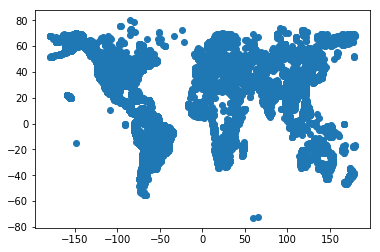

In [59]:
plt.scatter(Out[57].longitude, Out[57].latitude)

In [61]:
Out[57].work_type

0                         NaN
1                 Underground
2                         NaN
3                         NaN
4                         NaN
5                 Underground
6                         NaN
7                         NaN
8                         NaN
9                         NaN
10                        NaN
11                        NaN
12                        NaN
13                Underground
14                Underground
15                        NaN
16                        NaN
17                        NaN
18                        NaN
19                Underground
20                        NaN
21                        NaN
22        Surface/Underground
23                        NaN
24                        NaN
25                        NaN
26                        NaN
27                        NaN
28                        NaN
29                        NaN
                 ...         
304602                    NaN
304603                    NaN
304604    

In [62]:
import umap

In [63]:
all_points

,lat,long,country,year,positive,random
0,19.8101,93.987843,MMR,2007,1,0
1,22.8724,91.097318,BGD,2003,1,0
2,13.8577,107.101193,KHM,2005,1,0
3,12.4897,106.028751,KHM,2008,1,0
4,12.7879,107.101193,KHM,2009,1,0
5,12.5657,104.990963,KHM,2010,1,0
6,12.6926,104.900925,KHM,2005,1,0
7,14.1717,103.636272,KHM,2008,1,0
8,12.4897,106.028751,KHM,2006,1,0
9,11.8302,106.178679,KHM,newest,1,0


In [64]:
A_country = jusipy.country_features.All()
all_points = 

,lat,long,country,year,positive,random
0,19.8101,93.987843,MMR,2007,1,0
1,22.8724,91.097318,BGD,2003,1,0
2,13.8577,107.101193,KHM,2005,1,0
3,12.4897,106.028751,KHM,2008,1,0
4,12.7879,107.101193,KHM,2009,1,0
5,12.5657,104.990963,KHM,2010,1,0
6,12.6926,104.900925,KHM,2005,1,0
7,14.1717,103.636272,KHM,2008,1,0
8,12.4897,106.028751,KHM,2006,1,0
9,11.8302,106.178679,KHM,newest,1,0
